# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(10,300)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(140, 180, '$+ 10 \%$', fontsize=12)
        plt.text(150, 120, '$- 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - NN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(23, 17, '$- 10 \%$', fontsize=12)
        plt.text(19, 28, '$+ 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - NN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Building the Model

In [10]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 501, step=3),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        model.add(Dropout(0.05))
        #Applying a Batch Normalization Layer after Dense Layer
        #model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                  loss="mean_squared_error",
                  #metrics=['accuracy']
                 metrics = ['accuracy']
                 )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [11]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [14]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir_1',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 #callbacks=[EarlyStopping('val_loss', patience=20)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

Trial 2074 Complete [00h 03m 02s]
val_loss: 20967.876953125

Best val_loss So Far: 14.554914474487305
Total elapsed time: 03h 34m 18s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
39/39 [==============================] - 0s 2ms/step - loss: 251.9851 - accuracy: 0.0000e+00
Epoch 2/1000
39/39 [==============================] - 0s 1ms/step - loss: 328.8617 - accuracy: 0.0000e+00
Epoch 3/1000
39/39 [==============================] - 0s 1ms/step - loss: 361.4555 - accuracy: 0.0000e+00
Epoch 4/1000
39/39 [==============================] - 0s 1ms/step - loss: 252.6486 - accuracy: 0.0000e+00
Epoch 5/1000
39/39 [==============================] - 0s 1ms/step - loss: 288.0071 - accuracy: 0.0000e+00
Epoch 6/1000
39/39 [==============================] - 0s 1ms/step - loss: 262.3375 - accuracy: 0.0000e+00
Epoch 7/1000
39/39 [==============================] - 0s 1ms/step - loss: 311.5084 - accuracy: 0.0000e+00
Epoch 8/1000
39/39 [==============================] - 0s 1ms/step - loss: 268.5459 - a

39/39 [==============================] - 0s 1ms/step - loss: 291.5246 - accuracy: 0.0000e+00
Epoch 77/1000
39/39 [==============================] - 0s 974us/step - loss: 257.2169 - accuracy: 0.0000e+00
Epoch 78/1000
39/39 [==============================] - 0s 1ms/step - loss: 225.8713 - accuracy: 0.0000e+00
Epoch 79/1000
39/39 [==============================] - 0s 999us/step - loss: 262.0525 - accuracy: 0.0000e+00
Epoch 80/1000
39/39 [==============================] - 0s 999us/step - loss: 318.7091 - accuracy: 0.0000e+00
Epoch 81/1000
39/39 [==============================] - 0s 1ms/step - loss: 327.6620 - accuracy: 0.0000e+00
Epoch 82/1000
39/39 [==============================] - 0s 1ms/step - loss: 310.0735 - accuracy: 0.0000e+00
Epoch 83/1000
39/39 [==============================] - 0s 1ms/step - loss: 216.6543 - accuracy: 0.0000e+00
Epoch 84/1000
39/39 [==============================] - 0s 1ms/step - loss: 260.0557 - accuracy: 0.0000e+00
Epoch 85/1000
39/39 [========================

39/39 [==============================] - 0s 2ms/step - loss: 266.5011 - accuracy: 0.0000e+00
Epoch 153/1000
39/39 [==============================] - 0s 1ms/step - loss: 250.9696 - accuracy: 0.0000e+00
Epoch 154/1000
39/39 [==============================] - 0s 1ms/step - loss: 222.5677 - accuracy: 0.0000e+00
Epoch 155/1000
39/39 [==============================] - 0s 1ms/step - loss: 272.8980 - accuracy: 0.0000e+00
Epoch 156/1000
39/39 [==============================] - 0s 1ms/step - loss: 233.2776 - accuracy: 0.0000e+00
Epoch 157/1000
39/39 [==============================] - 0s 2ms/step - loss: 264.9005 - accuracy: 0.0000e+00
Epoch 158/1000
39/39 [==============================] - 0s 1ms/step - loss: 290.2807 - accuracy: 0.0000e+00
Epoch 159/1000
39/39 [==============================] - 0s 1ms/step - loss: 255.2519 - accuracy: 0.0000e+00
Epoch 160/1000
39/39 [==============================] - 0s 1ms/step - loss: 254.1846 - accuracy: 0.0000e+00
Epoch 161/1000
39/39 [=====================

39/39 [==============================] - 0s 948us/step - loss: 321.6041 - accuracy: 0.0000e+00
Epoch 228/1000
39/39 [==============================] - 0s 1ms/step - loss: 315.3282 - accuracy: 0.0000e+00
Epoch 229/1000
39/39 [==============================] - 0s 948us/step - loss: 182.3878 - accuracy: 0.0000e+00
Epoch 230/1000
39/39 [==============================] - 0s 974us/step - loss: 354.1945 - accuracy: 0.0000e+00
Epoch 231/1000
39/39 [==============================] - 0s 976us/step - loss: 276.4076 - accuracy: 0.0000e+00
Epoch 232/1000
39/39 [==============================] - 0s 923us/step - loss: 316.6234 - accuracy: 0.0000e+00
Epoch 233/1000
39/39 [==============================] - 0s 999us/step - loss: 281.0570 - accuracy: 0.0000e+00
Epoch 234/1000
39/39 [==============================] - 0s 1ms/step - loss: 201.8613 - accuracy: 0.0000e+00
Epoch 235/1000
39/39 [==============================] - 0s 974us/step - loss: 253.2662 - accuracy: 0.0000e+00
Epoch 236/1000
39/39 [=======

Epoch 302/1000
39/39 [==============================] - 0s 948us/step - loss: 359.1637 - accuracy: 0.0000e+00
Epoch 303/1000
39/39 [==============================] - 0s 974us/step - loss: 311.4840 - accuracy: 0.0000e+00
Epoch 304/1000
39/39 [==============================] - 0s 923us/step - loss: 283.8139 - accuracy: 0.0000e+00
Epoch 305/1000
39/39 [==============================] - 0s 1ms/step - loss: 234.2819 - accuracy: 0.0000e+00
Epoch 306/1000
39/39 [==============================] - 0s 2ms/step - loss: 226.5376 - accuracy: 0.0000e+00
Epoch 307/1000
39/39 [==============================] - 0s 2ms/step - loss: 278.5174 - accuracy: 0.0000e+00
Epoch 308/1000
39/39 [==============================] - 0s 1ms/step - loss: 250.4053 - accuracy: 0.0000e+00
Epoch 309/1000
39/39 [==============================] - 0s 1ms/step - loss: 251.2320 - accuracy: 0.0000e+00
Epoch 310/1000
39/39 [==============================] - 0s 2ms/step - loss: 309.6109 - accuracy: 0.0000e+00
Epoch 311/1000
39/39 [

39/39 [==============================] - 0s 2ms/step - loss: 290.1124 - accuracy: 0.0000e+00
Epoch 377/1000
39/39 [==============================] - 0s 2ms/step - loss: 246.1289 - accuracy: 0.0000e+00
Epoch 378/1000
39/39 [==============================] - 0s 2ms/step - loss: 252.8136 - accuracy: 0.0000e+00
Epoch 379/1000
39/39 [==============================] - 0s 2ms/step - loss: 334.0219 - accuracy: 0.0000e+00
Epoch 380/1000
39/39 [==============================] - 0s 2ms/step - loss: 257.5028 - accuracy: 0.0000e+00
Epoch 381/1000
39/39 [==============================] - 0s 2ms/step - loss: 285.3323 - accuracy: 0.0000e+00
Epoch 382/1000
39/39 [==============================] - 0s 2ms/step - loss: 348.4512 - accuracy: 0.0000e+00
Epoch 383/1000
39/39 [==============================] - 0s 2ms/step - loss: 216.2625 - accuracy: 0.0000e+00: 0s - loss: 209.8634 - accuracy: 0.0000e+
Epoch 384/1000
39/39 [==============================] - 0s 2ms/step - loss: 241.1093 - accuracy: 0.0000e+00
E

39/39 [==============================] - 0s 2ms/step - loss: 234.8861 - accuracy: 0.0000e+00
Epoch 452/1000
39/39 [==============================] - 0s 2ms/step - loss: 249.7299 - accuracy: 0.0000e+00
Epoch 453/1000
39/39 [==============================] - 0s 2ms/step - loss: 221.7308 - accuracy: 0.0000e+00
Epoch 454/1000
39/39 [==============================] - 0s 2ms/step - loss: 244.6087 - accuracy: 0.0000e+00
Epoch 455/1000
39/39 [==============================] - 0s 2ms/step - loss: 239.0535 - accuracy: 0.0000e+00
Epoch 456/1000
39/39 [==============================] - 0s 2ms/step - loss: 306.5018 - accuracy: 0.0000e+00
Epoch 457/1000
39/39 [==============================] - 0s 1ms/step - loss: 225.9997 - accuracy: 0.0000e+00
Epoch 458/1000
39/39 [==============================] - 0s 2ms/step - loss: 185.2145 - accuracy: 0.0000e+00
Epoch 459/1000
39/39 [==============================] - 0s 2ms/step - loss: 250.6361 - accuracy: 0.0000e+00
Epoch 460/1000
39/39 [=====================

39/39 [==============================] - 0s 2ms/step - loss: 309.8006 - accuracy: 0.0000e+00
Epoch 527/1000
39/39 [==============================] - 0s 2ms/step - loss: 289.6546 - accuracy: 0.0000e+00
Epoch 528/1000
39/39 [==============================] - 0s 2ms/step - loss: 230.2737 - accuracy: 0.0000e+00
Epoch 529/1000
39/39 [==============================] - 0s 2ms/step - loss: 320.0827 - accuracy: 0.0000e+00
Epoch 530/1000
39/39 [==============================] - 0s 2ms/step - loss: 235.1521 - accuracy: 0.0000e+00
Epoch 531/1000
39/39 [==============================] - 0s 1ms/step - loss: 332.5497 - accuracy: 0.0000e+00
Epoch 532/1000
39/39 [==============================] - 0s 1ms/step - loss: 310.7466 - accuracy: 0.0000e+00
Epoch 533/1000
39/39 [==============================] - 0s 948us/step - loss: 259.0699 - accuracy: 0.0000e+00
Epoch 534/1000
39/39 [==============================] - 0s 974us/step - loss: 354.2691 - accuracy: 0.0000e+00
Epoch 535/1000
39/39 [=================

39/39 [==============================] - 0s 2ms/step - loss: 306.5444 - accuracy: 0.0000e+00
Epoch 602/1000
39/39 [==============================] - 0s 2ms/step - loss: 241.8467 - accuracy: 0.0000e+00
Epoch 603/1000
39/39 [==============================] - 0s 1ms/step - loss: 288.8836 - accuracy: 0.0000e+00
Epoch 604/1000
39/39 [==============================] - 0s 1ms/step - loss: 281.8060 - accuracy: 0.0000e+00
Epoch 605/1000
39/39 [==============================] - 0s 974us/step - loss: 276.5630 - accuracy: 0.0000e+00
Epoch 606/1000
39/39 [==============================] - 0s 999us/step - loss: 281.5422 - accuracy: 0.0000e+00
Epoch 607/1000
39/39 [==============================] - 0s 1ms/step - loss: 198.0565 - accuracy: 0.0000e+00
Epoch 608/1000
39/39 [==============================] - 0s 1ms/step - loss: 292.8024 - accuracy: 0.0000e+00
Epoch 609/1000
39/39 [==============================] - 0s 2ms/step - loss: 317.2344 - accuracy: 0.0000e+00
Epoch 610/1000
39/39 [=================

39/39 [==============================] - 0s 2ms/step - loss: 267.7912 - accuracy: 0.0000e+00
Epoch 677/1000
39/39 [==============================] - 0s 2ms/step - loss: 238.4429 - accuracy: 0.0000e+00
Epoch 678/1000
39/39 [==============================] - 0s 2ms/step - loss: 288.8311 - accuracy: 0.0000e+00
Epoch 679/1000
39/39 [==============================] - 0s 2ms/step - loss: 256.4411 - accuracy: 0.0000e+00
Epoch 680/1000
39/39 [==============================] - 0s 2ms/step - loss: 258.4433 - accuracy: 0.0000e+00
Epoch 681/1000
39/39 [==============================] - 0s 1ms/step - loss: 278.3587 - accuracy: 0.0000e+00
Epoch 682/1000
39/39 [==============================] - 0s 2ms/step - loss: 235.4541 - accuracy: 0.0000e+00
Epoch 683/1000
39/39 [==============================] - 0s 2ms/step - loss: 261.8499 - accuracy: 0.0000e+00
Epoch 684/1000
39/39 [==============================] - 0s 2ms/step - loss: 298.8523 - accuracy: 0.0000e+00
Epoch 685/1000
39/39 [=====================

39/39 [==============================] - 0s 2ms/step - loss: 303.2516 - accuracy: 0.0000e+00
Epoch 752/1000
39/39 [==============================] - 0s 1ms/step - loss: 329.9969 - accuracy: 0.0000e+00
Epoch 753/1000
39/39 [==============================] - 0s 2ms/step - loss: 271.1589 - accuracy: 0.0000e+00
Epoch 754/1000
39/39 [==============================] - 0s 2ms/step - loss: 214.7839 - accuracy: 0.0000e+00
Epoch 755/1000
39/39 [==============================] - 0s 2ms/step - loss: 235.3356 - accuracy: 0.0000e+00
Epoch 756/1000
39/39 [==============================] - 0s 1ms/step - loss: 275.1098 - accuracy: 0.0000e+00
Epoch 757/1000
39/39 [==============================] - 0s 2ms/step - loss: 279.2554 - accuracy: 0.0000e+00
Epoch 758/1000
39/39 [==============================] - 0s 2ms/step - loss: 253.2654 - accuracy: 0.0000e+00
Epoch 759/1000
39/39 [==============================] - 0s 2ms/step - loss: 273.9402 - accuracy: 0.0000e+00
Epoch 760/1000
39/39 [=====================

Epoch 826/1000
39/39 [==============================] - 0s 1ms/step - loss: 305.7300 - accuracy: 0.0000e+00
Epoch 827/1000
39/39 [==============================] - 0s 1ms/step - loss: 326.3319 - accuracy: 0.0000e+00
Epoch 828/1000
39/39 [==============================] - 0s 2ms/step - loss: 405.5311 - accuracy: 0.0000e+00: 0s - loss: 449.4914 - accuracy: 0.0000e+
Epoch 829/1000
39/39 [==============================] - 0s 2ms/step - loss: 303.8445 - accuracy: 0.0000e+00
Epoch 830/1000
39/39 [==============================] - 0s 1ms/step - loss: 256.3744 - accuracy: 0.0000e+00
Epoch 831/1000
39/39 [==============================] - 0s 974us/step - loss: 264.4388 - accuracy: 0.0000e+00
Epoch 832/1000
39/39 [==============================] - 0s 999us/step - loss: 266.4524 - accuracy: 0.0000e+00
Epoch 833/1000
39/39 [==============================] - 0s 1ms/step - loss: 301.4432 - accuracy: 0.0000e+00
Epoch 834/1000
39/39 [==============================] - 0s 923us/step - loss: 250.7307 - a

39/39 [==============================] - 0s 2ms/step - loss: 237.7597 - accuracy: 0.0000e+00
Epoch 901/1000
39/39 [==============================] - 0s 2ms/step - loss: 294.8381 - accuracy: 0.0000e+00
Epoch 902/1000
39/39 [==============================] - 0s 2ms/step - loss: 184.8629 - accuracy: 0.0000e+00
Epoch 903/1000
39/39 [==============================] - ETA: 0s - loss: 284.1423 - accuracy: 0.0000e+ - 0s 2ms/step - loss: 288.5937 - accuracy: 0.0000e+00
Epoch 904/1000
39/39 [==============================] - 0s 1ms/step - loss: 318.4500 - accuracy: 0.0000e+00
Epoch 905/1000
39/39 [==============================] - 0s 2ms/step - loss: 310.9814 - accuracy: 0.0000e+00
Epoch 906/1000
39/39 [==============================] - 0s 2ms/step - loss: 317.9973 - accuracy: 0.0000e+00
Epoch 907/1000
39/39 [==============================] - 0s 2ms/step - loss: 293.9301 - accuracy: 0.0000e+00
Epoch 908/1000
39/39 [==============================] - 0s 2ms/step - loss: 246.2360 - accuracy: 0.0000

39/39 [==============================] - 0s 2ms/step - loss: 265.8241 - accuracy: 0.0000e+00
Epoch 975/1000
39/39 [==============================] - 0s 2ms/step - loss: 284.3239 - accuracy: 0.0000e+00
Epoch 976/1000
39/39 [==============================] - 0s 2ms/step - loss: 273.8766 - accuracy: 0.0000e+00
Epoch 977/1000
39/39 [==============================] - 0s 1ms/step - loss: 257.5022 - accuracy: 0.0000e+00
Epoch 978/1000
39/39 [==============================] - 0s 2ms/step - loss: 223.4190 - accuracy: 0.0000e+00
Epoch 979/1000
39/39 [==============================] - 0s 2ms/step - loss: 254.2360 - accuracy: 0.0000e+00
Epoch 980/1000
39/39 [==============================] - 0s 2ms/step - loss: 335.5871 - accuracy: 0.0000e+00
Epoch 981/1000
39/39 [==============================] - 0s 2ms/step - loss: 233.2780 - accuracy: 0.0000e+00
Epoch 982/1000
39/39 [==============================] - 0s 2ms/step - loss: 288.7049 - accuracy: 0.0000e+00
Epoch 983/1000
39/39 [=====================

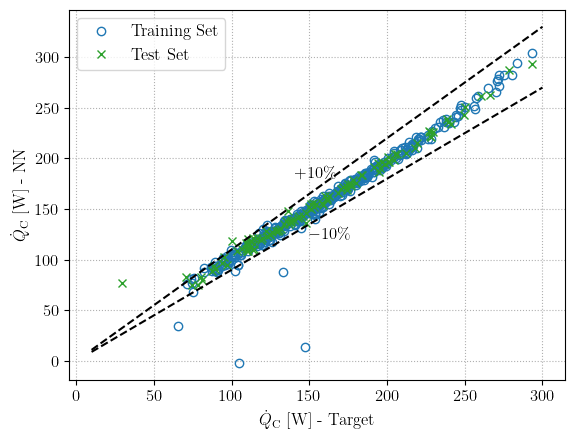

In [15]:
NeuNet(X_train,y_train,1000,'Qc')